In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.model_selection as sk
from sklearn.naive_bayes import GaussianNB as gnb
from sklearn.tree import DecisionTreeClassifier as dtc
from sklearn.linear_model import Perceptron as pc
from sklearn.neural_network import MLPClassifier as mlp
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# Data 

In [2]:
drug_data = pd.read_csv('drug200.csv')

drug_data

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,drugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,drugY
...,...,...,...,...,...,...
195,56,F,LOW,HIGH,11.567,drugC
196,16,M,LOW,HIGH,12.006,drugC
197,52,M,NORMAL,HIGH,9.894,drugX
198,23,M,NORMAL,NORMAL,14.020,drugX


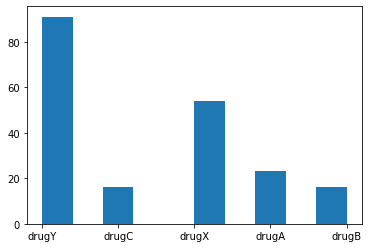

In [3]:
# Need to add axis labels and title

x = plt.hist(drug_data.Drug)
plt.savefig('Drug_Distribution_Data.pdf')

In [4]:
N_to_K = drug_data.Na_to_K
Age = drug_data.Age
Sex_nf = pd.get_dummies(drug_data.Sex)
BP_nf = pd.Categorical(drug_data.BP, ordered = True, categories = ['LOW', 'NORMAL', 'HIGH'])
Chol_nf = pd.Categorical(drug_data.Cholesterol, ordered = True, categories = ['NORMAL', 'HIGH'])
BP_nf = pd.DataFrame({'BP': BP_nf.codes})
Chol_nf = pd.DataFrame({'Cholesterol' :Chol_nf.codes})

In [5]:
drug_features = [Age, Sex_nf, BP_nf, Chol_nf, N_to_K]
drug_features = pd.concat(drug_features, axis=1, join = 'inner')
drug_target = drug_data.Drug

In [6]:
x_train, x_test, y_train, y_test = sk.train_test_split(drug_features, drug_target)
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

# Metrics

In [7]:
def getMetrics(drug_classes, index, pred, targets):
    class_recall = recall_score(targets, pred, average= None)
    class_precision = precision_score(targets, pred, average= None, zero_division = 0)
    class_f1 = f1_score(targets, pred, average= None)
    model_accuracy = accuracy_score(targets, pred)
    model_f1_macro = f1_score(targets, pred, average= 'macro')
    model_f1_weighted = f1_score(targets, pred, average= 'weighted')

    class_recall_labelled = {}
    class_precision_labelled = {}
    class_f1_labelled = {}
    
    for i in range(len(drug_classes)):
        class_recall_labelled[drug_classes[i]] = class_recall[i]
        class_precision_labelled[drug_classes[i]] = class_precision[i]
        class_f1_labelled[drug_classes[i]] = class_f1[i]
    
    metrics = {'Accuracy': model_accuracy, 'F1 Macro': model_f1_macro, 'F1 Weighted' : model_f1_weighted, \
               'Class Recall': class_recall_labelled, 'Class Precision' : class_precision_labelled, 'Class F1': class_f1_labelled}
    
    return metrics
    

# Print Metrics 

In [8]:
def print_model_file(model, file):
    with open(file, 'a') as metrics_file:
        metrics_file.write('\n(A)\n\n')
        if type(model) != 'GridSearchCV':
            metrics_file.write("********************************************************************************\n" +
            type(model).__name__ + '\n'
            'Parameters: '+ ' ' + str(model._get_param_names()) + '\n'+
            "********************************************************************************\n")

        else:
            metrics_file.write("********************************************************************************\n" +
            model.get_params()['estimator'] + ' ' +type(model).___name__ + '\n'   +              
            'Parameters: '+ ' ' + str(model.best_params_) + '\n'+
            "********************************************************************************\n")
            
        
def print_metrics_file(metrics, file):
    with open(file, 'a') as metrics_file:
        metrics_file.write('\n\n(C)')
        
        for key, value in metrics.items():            
            if type(metrics[key]) == dict:
                metrics_file.write('\n\n' +key)
                for key2, value2 in metrics[key].items():
                    metrics_file.write('\n   ' +str(key2) + ' ' + str(value2))
        
        metrics_file.write('\n\n(D)')
        for key, value in metrics.items():
                if type(metrics[key]) != dict :
                    metrics_file.write('\n\n' +str(key) + ' ' + str(value))
        metrics_file.write('\n\n')
    
    
def print_matrix_file(model, pred, targets, file):
    drug_classes = model.classes_
    cm = confusion_matrix(targets, pred, labels = drug_classes)
    drug_classes = [x[-1] for x in drug_classes]
    
    with open(file, 'a') as metrics_file:
        elements = '{:<3} {:<3} {:<3} {:<3} {:<3}'
        metrics_file.write('\n(B)\n\n')
        for i in range(len(drug_classes)):
            elements = elements.format(cm[i, 0], cm[i, 1], cm[i, 2], cm[i, 3], cm[i, 4])
            print(elements)
            metrics_file.write(drug_classes[i] + '  ' + elements+ '\n')
            elements ='{:<3} {:<3} {:<3} {:<3} {:<3}'
        metrics_file.write('   '+'   '.join(drug_classes))



# Guassian Naive-Bayes

In [9]:
cl_gnb = gnb().fit(x_train, y_train)

In [11]:
predictions_cl_gnb = cl_gnb.predict(x_train).reshape(150, 1)
index = x_train.index.values.reshape(150, 1)
targets_cl_gnb = y_train.reshape(150, 1)


drug_classes=cl_gnb.classes_
metrics_gnb = getMetrics(drug_classes, index, predictions_cl_gnb, targets_cl_gnb)

print_model_file(cl_gnb, 'drug-performance.txt')
print_matrix_file(cl_gnb, predictions_cl_gnb, targets_cl_gnb, 'drug-performance.txt')
print_metrics_file(metrics_gnb, 'drug-performance.txt')

# Decision Tree

In [12]:
cl_dtc = dtc().fit(x_train, y_train)

In [13]:
predictions_cl_dtc = cl_dtc.predict(x_test).reshape(50, 1)
index = x_test.index.values.reshape(50, 1)
targets_cl_dtc = y_test.reshape(50, 1)

drug_classes=cl_dtc.classes_
metrics_dtc = getMetrics(drug_classes, index, predictions_cl_dtc, targets_cl_dtc)

print_model_file(cl_dtc, 'drug-performance.txt')
print_matrix_file(cl_dtc, predictions_cl_dtc, targets_cl_dtc, 'drug-performance.txt')
print_metrics_file(metrics_dtc, 'drug-performance.txt')

# Top- DT

In [14]:
cl_topdtc = dtc()
cl_topdtc.get_params()
params = {'criterion': ['entropy', 'gini'], 'max_depth' : [1, 2, 3, 4, 5, 3, 7 ], 'min_samples_split': [2, 3, 4]}
sc_dtc = sk.GridSearchCV(cl_topdtc, params, scoring='f1_weighted')

In [15]:
sc_dtc.fit(x_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [1, 2, 3, 4, 5, 3, 7],
                         'min_samples_split': [2, 3, 4]},
             scoring='f1_weighted')

In [16]:
predictions_cl_topdtc = sc_dtc.predict(x_test).reshape(50, 1)
index = x_test.index.values.reshape(50, 1)
targets_cl_topdtc = y_test.reshape(50, 1)

drug_classes=sc_dtc.classes_
metrics_topdtc = getMetrics(drug_classes, index, predictions_cl_topdtc, targets_cl_topdtc)

print_model_file(sc_dtc, 'drug-performance.txt')
print_matrix_file(sc_dtc, predictions_cl_topdtc, targets_cl_topdtc, 'drug-performance.txt')
print_metrics_file(metrics_topdtc, 'drug-performance.txt')

# Perceptron

In [17]:
cl_pc = pc()

pc_x_train = x_train.to_numpy()
pc_x_test = x_test.to_numpy()

In [18]:
cl_pc.fit(pc_x_train, y_train)

Perceptron()

In [19]:
predictions_cl_pc = cl_pc.predict(pc_x_test).reshape(50, 1)
index = x_test.index.values.reshape(50,1)
targets_cl_pc = y_test.reshape(50, 1)

drug_classes=cl_pc.classes_
metrics_pc = getMetrics(drug_classes, index, predictions_cl_pc, targets_cl_pc)

print_model_file(cl_pc, 'test.txt')
print_matrix_file(cl_dtc, predictions_cl_pc, targets_cl_pc, 'test.txt')
print_metrics_file(metrics_pc, 'test.txt')

# MLP

In [20]:
cl_mlp = mlp(hidden_layer_sizes = (1, 100), activation = 'logistic', solver = 'sgd')

In [21]:
cl_mlp.fit(x_train, y_train)

MLPClassifier(activation='logistic', hidden_layer_sizes=(1, 100), solver='sgd')

In [22]:
predictions_cl_mlp = cl_mlp.predict(x_test).reshape(50, 1)
index = x_test.index.values.reshape(50,1)
targets_cl_mlp = y_test.reshape(50, 1)

drug_classes=cl_mlp.classes_
metrics_mlp = getMetrics(drug_classes, index, predictions_cl_mlp, targets_cl_mlp)


print_model_file(cl_mlp, 'drug-performance.txt')
print_matrix_file(cl_mlp, predictions_cl_mlp, targets_cl_mlp, 'drug-performance.txt')
print_metrics_file(metrics_mlp, 'drug-performance.txt')

# Top MLP

In [23]:
cl_topmlp = mlp()

In [24]:
params = {'activation': ['logistic', 'tanh', 'relu', 'identity'], 'hidden_layer_sizes': [(20, 50), (10, 10, 10)]}

sc_mlp = sk.GridSearchCV(cl_topmlp, params)

sc_mlp.fit(x_train, y_train)


C:\Users\bdelp\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bdelp\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bdelp\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bdelp\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bdelp\anaconda3\lib\site-packages\sklearn\neural_network\_multi

C:\Users\bdelp\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bdelp\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


GridSearchCV(estimator=MLPClassifier(),
             param_grid={'activation': ['logistic', 'tanh', 'relu', 'identity'],
                         'hidden_layer_sizes': [(20, 50), (10, 10, 10)]})

In [25]:
predictions_cl_topmlp = sc_mlp.predict(x_test).reshape(50, 1)
index = x_test.index.values.reshape(50, 1)
targets_cl_topmlp = y_test.reshape(50, 1)

drug_classes=sc_mlp.classes_
metrics_topmlp = getMetrics(drug_classes, index, predictions_cl_topmlp, targets_cl_topmlp)

# Average and Standard Deviation

In [26]:
with open('drug-performance.txt', 'a') as metrics:
    metrics.write('---Metrics---\n\n')
    metrics.write('Gaussian\n')
    metrics.write('Accuracy  ' + str(metrics_gnb['Accuracy']) + '\n')
    metrics.write('F1-Macro  ' + str(metrics_gnb['F1 Macro'])+ '\n')
    metrics.write('F1-Weighted  ' + str(metrics_gnb['F1 Weighted'])+ '\n\n')
    
    metrics.write('Decision Tree\n')
    metrics.write('Accuracy  ' + str(metrics_dtc['Accuracy'])+ '\n')
    metrics.write('F1-Macro  ' + str(metrics_dtc['F1 Macro'])+ '\n')
    metrics.write('F1-Weighted  ' + str(metrics_dtc['F1 Weighted'])+ '\n\n')
    
    metrics.write('Top-Decision Tree\n')
    metrics.write('Accuracy  ' + str(metrics_topdtc['Accuracy'])+ '\n')
    metrics.write('F1-Macro  ' + str(metrics_topdtc['F1 Macro'])+ '\n')
    metrics.write('F1-Weighted  ' + str(metrics_topdtc['F1 Weighted'])+ '\n\n')

    metrics.write('Perceptron\n')
    metrics.write('Accuracy  ' + str(metrics_pc['Accuracy'])+ '\n')
    metrics.write('F1-Macro  ' + str(metrics_pc['F1 Macro'])+ '\n')
    metrics.write('F1-Weighted  ' + str(metrics_pc['F1 Weighted'])+ '\n\n')

    metrics.write('MLP\n')
    metrics.write('Accuracy  ' + str(metrics_mlp['Accuracy'])+ '\n')
    metrics.write('F1-Macro  ' + str(metrics_mlp['F1 Macro'])+ '\n')
    metrics.write('F1-Weighted  ' + str(metrics_mlp['F1 Weighted'])+ '\n\n')

    metrics.write('Top MLP\n')
    metrics.write('Accuracy  ' + str(metrics_topmlp['Accuracy'])+ '\n')
    metrics.write('F1-Macro  ' + str(metrics_topmlp['F1 Macro'])+ '\n')
    metrics.write('F1-Weighted  ' + str(metrics_topmlp['F1 Weighted'])+ '\n\n')

In [27]:
d= {}
cl = [[[],[],[]],[[],[],[]],[[],[],[]],[[],[],[],],[[],[],[]],[[],[],[]]]

with open('drug-performance.txt', 'r') as metrics:
    l = metrics.readline()
    read = False
    skip = False
    count = 3
    cl_count = 0
    while l:
        if '---Metrics---' in l: 
            cl_count = 0
            read = True
            skip = True
            
        if read == True and skip == True:
            for i in range(2) : l = metrics.readline()
            skip = False
            
        elif read == True and skip != True and count > 0:
            (key, value) = l.split()
            d[key] = value
            count = count -1
            
        if count == 0:
            cl[cl_count][0].append(d['Accuracy'])
            cl[cl_count][1].append(d['F1-Macro'])
            cl[cl_count][2].append(d['F1-Weighted'])
            count = 3
            skip = True
            cl_count = cl_count+1
            
        else:
            l = metrics.readline()
        
        if cl_count == 6:
            cl_count = 0
            l = metrics.readline()
            l = metrics.readline()

Accuracy  0.8933333333333333

F1-Macro  0.8809523809523808

F1-Weighted  0.8949206349206349

Accuracy  0.98

F1-Macro  0.9314285714285713

F1-Weighted  0.9794285714285715

Accuracy  0.98

F1-Macro  0.9314285714285713

F1-Weighted  0.9794285714285715

Accuracy  0.28

F1-Macro  0.13999999999999999

F1-Weighted  0.30599999999999994

Accuracy  0.54

F1-Macro  0.14025974025974025

F1-Weighted  0.3787012987012987

Accuracy  0.76

F1-Macro  0.5364008926759991

F1-Weighted  0.7233791844187462

F1-Weighted  0.7233791844187462
5
Accuracy  0.8533333333333334

F1-Macro  0.8403720420463243

F1-Weighted  0.856906608424374

Accuracy  0.98

F1-Macro  0.9894949494949495

F1-Weighted  0.9799191919191919

Accuracy  0.98

F1-Macro  0.9894949494949495

F1-Weighted  0.9799191919191919

Accuracy  0.7

F1-Macro  0.3143434343434343

F1-Weighted  0.6188282828282828

Accuracy  0.44

F1-Macro  0.12222222222222223

F1-Weighted  0.26888888888888896

Accuracy  0.82

F1-Macro  0.6533333333333332

F1-Weighted  0.78233

In [206]:
count = 0
average =  [[[],[],[]],[[],[],[]],[[],[],[]],[[],[],[],],[[],[],[]],[[],[],[]]]
cl = np.array(cl)
cl = cl.astype(np.float)

for i in range(len(cl)):
    for j in range(len(cl[i])):
        count = sum(cl[i][j])
        average[i][j] = count/10
        
average = np.array(average)
average.shape


(6, 3)

In [273]:
with open('drug-performance.txt', 'a') as metrics:
    metrics.write('Average of Guassian Accuracy ' + str(average[0][0]) + '\n')
    metrics.write('Average of Guassian F1 Macro ' + str(average[0][1]) + '\n')
    metrics.write('Average of Guassian F1 Weighted ' + str(average[0][2]) + '\n')
    metrics.write('Average of Decision Tree Accuracy ' + str(average[1][0]) + '\n')
    metrics.write('Average of Decision Tree F1 Macro ' + str(average[1][1]) + '\n')
    metrics.write('Average of Decision Tree F1 Weighted ' + str(average[1][2]) + '\n')
    metrics.write('Average of Top Decision Tree Accuracy ' + str(average[2][0]) + '\n')
    metrics.write('Average of Top Decision Tree F1 Macro ' + str(average[2][1]) + '\n')
    metrics.write('Average of Top Decision Tree F1 Weighted ' + str(average[2][2]) + '\n')
    metrics.write('Average of Preceptron Accuracy ' + str(average[3][0]) + '\n')
    metrics.write('Average of Preceptron F1 Macro ' + str(average[3][1]) + '\n')
    metrics.write('Average of Preceptron F1 Weighted ' + str(average[3][2]) + '\n')
    metrics.write('Average of MLP Accuracy ' + str(average[4][0]) + '\n')
    metrics.write('Average of MLP F1 Macro ' + str(average[4][1]) + '\n')
    metrics.write('Average of MLP F1 Weighted ' + str(average[4][2]) + '\n')
    metrics.write('Average of Top MLP Accuracy ' + str(average[5][0]) + '\n')
    metrics.write('Average of Top MLP F1 Macro ' + str(average[5][1]) + '\n')
    metrics.write('Average of Top MLP F1 Weighted ' + str(average[5][2]) + '\n\n')

In [275]:
with open('drug-performance.txt', 'a') as metrics:
    metrics.write('Standard Deviation of Guassian Accuracy ' +str(sum(((cl[0][0] - average[0][0])**2)/10)) + '\n')
    metrics.write('Standard Deviation of Guassian F1 Macro ' +str(sum(((cl[0][1] - average[0][1])**2)/10)) + '\n')
    metrics.write('Standard Deviation of Guassian F1 Weighted ' +str(sum(((cl[0][2] - average[0][2])**2)/10)) + '\n')
    metrics.write('Standard Deviation of Decision Tree Accuracy ' +str(sum(((cl[1][0] - average[1][0])**2)/10)) + '\n')
    metrics.write('Standard Deviation of Decision Tree F1 Macro ' +str(sum(((cl[1][1] - average[1][1])**2)/10)) + '\n')
    metrics.write('Standard Deviation of Decision Tree F1 Weighted ' +str(sum(((cl[1][2] - average[1][2])**2)/10)) + '\n')
    metrics.write('Standard Deviation of Top Decision Tree Accuracy ' +str(sum(((cl[2][0] - average[2][0])**2)/10)) + '\n')
    metrics.write('Standard Deviation of Top Decision Tree F1 Macro ' +str(sum(((cl[2][1] - average[2][1])**2)/10)) + '\n')
    metrics.write('Standard Deviation of Top Decision Tree F1 Weighted ' +str(sum(((cl[2][2] - average[2][2])**2)/10)) + '\n')
    metrics.write('Standard Deviation of Preceptron Accuracy ' +str(sum(((cl[3][0] - average[3][0])**2)/10)) + '\n')
    metrics.write('Standard Deviation of Preceptron F1 Macro ' +str(sum(((cl[3][1] - average[3][1])**2)/10)) + '\n')
    metrics.write('Standard Deviation of Preceptron F1 Weighted ' +str(sum(((cl[3][2] - average[3][2])**2)/10)) + '\n')
    metrics.write('Standard Deviation of MLP Accuracy ' +str(sum(((cl[4][0] - average[4][0])**2)/10)) + '\n')
    metrics.write('Standard Deviation of MLP F1 Macro ' +str(sum(((cl[4][1] - average[4][1])**2)/10)) + '\n')
    metrics.write('Standard Deviation of MLP F1 Weighted ' +str(sum(((cl[4][2]- average[4][2])**2)/10) )+ '\n')
    metrics.write('Standard Deviation of Top MLP Accuracy ' +str(sum(((cl[5][0] - average[5][0])**2)/10)) + '\n')
    metrics.write('Standard Deviation of Top MLP F1 Macro ' +str(sum(((cl[5][1] - average[5][1])**2)/10)) + '\n')
    metrics.write('Standard Deviation of Top MLP F1 Weighted ' +str(sum(((cl[5][2] - average[5][2])**2)/10)) + '\n')